## Setup evnironment

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from glob import glob
import json
import mvranalysis as mvr
import seaborn as sns
from scipy import interpolate

//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Setup plotting

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
#import seaborn as sns
#sns.set_context('paper')
#sns.set_style('ticks')

In [3]:
path = '/Volumes/freeman/Nick/mVR/sessions/000164'
session = mvr.load_session(path)

In [4]:
maze = mvr.loadMazeMat(path+'/behavior')

OneChoiceRWcts.mat


In [5]:
session.to_csv(path + '/behavior/session.csv')

IOError: [Errno 16] Resource busy: '/Volumes/freeman/Nick/mVR/sessions/000164/behavior/session.csv'

#### Create trial summary

In [8]:
trial = session[['trialType','number']].groupby(['number'], sort=True).first()
trial = trial[:len(trial)-1]
trial = trial.join(session[['reward','number','rEnd','lEnd']].groupby(['number'], sort=True).max())
print len(trial)

90


In [9]:
#Returns table of all trials and whether or not they entered a specific branch
def trialEntered(branchId):
    keep = session[['curBranchId','number']].groupby(['number'], sort=True).agg(lambda x : branchId in x.values)
    return keep

In [10]:
a = [1,2,3,4,5,5]
a[:len(a)-1]

[1, 2, 3, 4, 5]

## Plot data

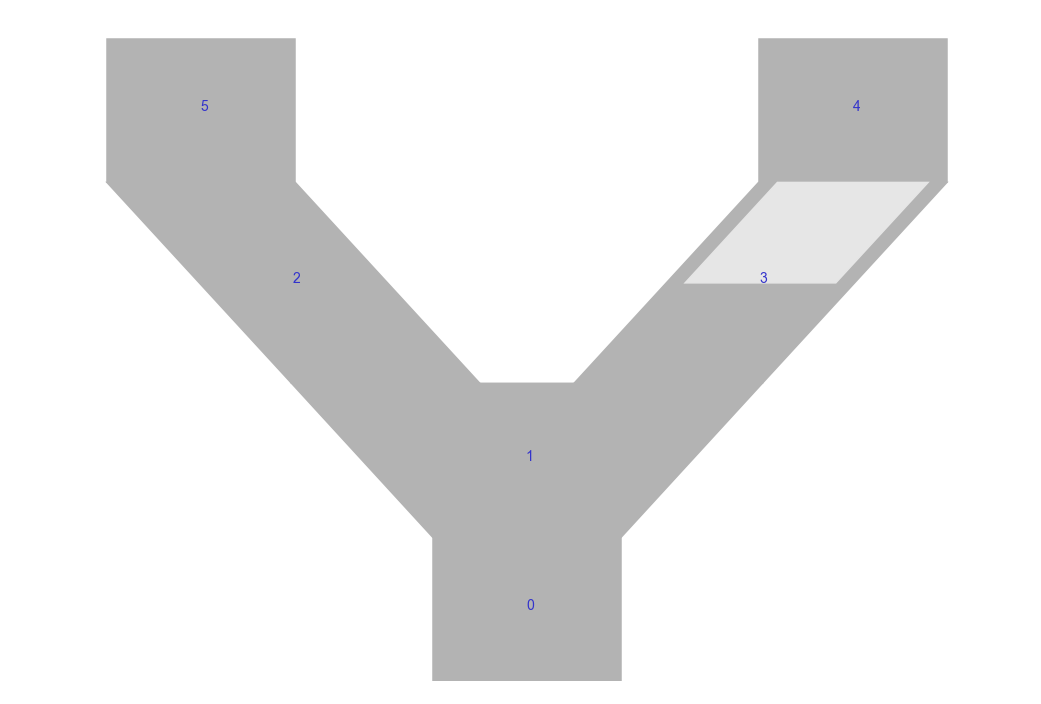

In [11]:
plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)

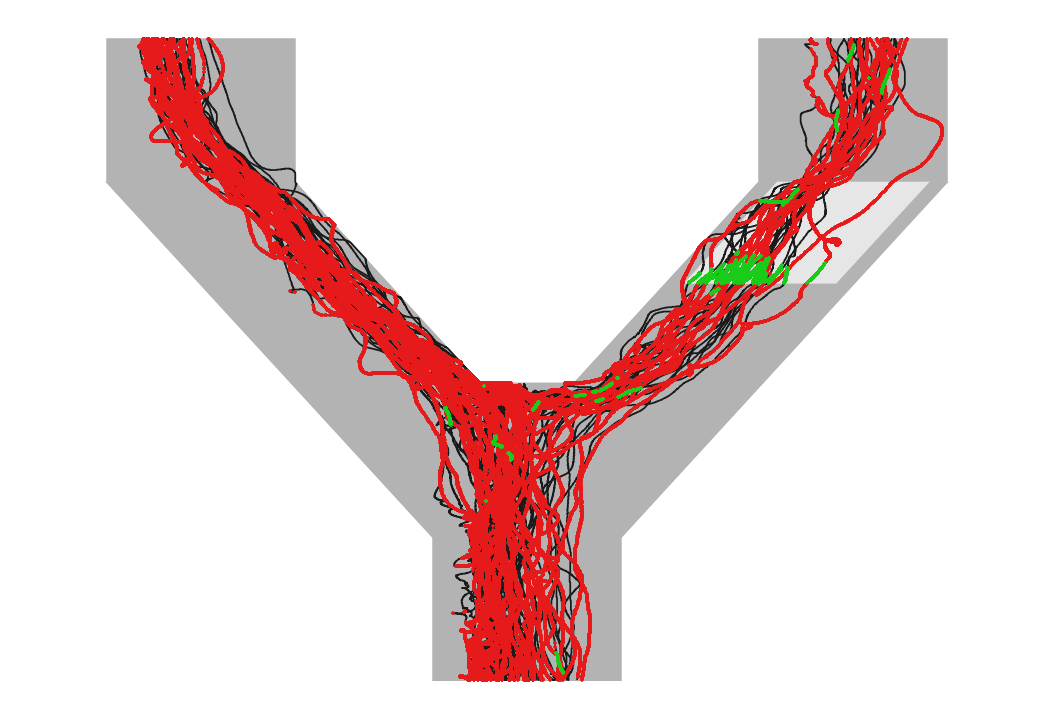

In [12]:
plt.figure(figsize=[18,12])
Id = 0
keep = trial[trial.trialType == Id].index.tolist()
mvr.draw(maze[Id],False)
mvr.trace(session, keep, [0.1, 0.1, 0.1])
mvr.licks(session, keep, [0.9, 0.1, 0.1])
mvr.water(session, keep, [0.1, 0.8, 0.1])

In [13]:
def pathlength(x,y,degree=3)  :
    '''
    x and y arrays must have the same dimensions
    Implements arclength formula to estimate the total length of a fitted spline (cubic default)
    
    Returns: x(t) spline, y(t) spline, path length
    ''' 
    
    t = range(len(x)) #time series
    fx = interpolate.UnivariateSpline(t, x, k=degree)
    fy = interpolate.UnivariateSpline(t, y, k=degree)
    #print len(x),len(fx(t))
    x_coef = fx.get_coeffs()[~np.isnan(fx.get_coeffs())]
    y_coef = fy.get_coeffs()[~np.isnan(fy.get_coeffs())]
    
    dxdt = fx.derivative()
    dydt = fy.derivative()

    dx_array = [dxdt(xi) for xi in t]
    dy_array = [dydt(yi) for yi in t]

    dx2 = np.square(dx_array)
    dy2 = np.square(dy_array)

    hyp2 = np.add(dx2,dy2)
    integrand = np.sqrt(hyp2)

    length = sum(integrand)

    
    return fx, fy,length 

In [14]:
def fitpath(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial :   
        xCord = session.xMazePos[(session.number == t) & ~session.iti].values[:-100]
        yCord = session.yMazePos[(session.number == t) & ~session.iti].values[:-100] 
    
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 

In [15]:
plen = fitpath(session,keep)
trial['Pathlengths'] = plen

In [16]:
def choicepath(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial :   
        xCord = session.xMazePos[(session.number == t) & (session.curBranchId == 1) & ~session.iti].values
        yCord = session.yMazePos[(session.number == t) & (session.curBranchId == 1) & ~session.iti].values
        if len(xCord)==0:
            pathlengths.append('NaN')
            continue
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 
choicelen = choicepath(session,keep)
trial['choicePath'] = choicelen
#trial


In [17]:
trial

,trialType,reward,rEnd,lEnd,Pathlengths,choicePath
number,,,,,,
0,0,0,0,0,95.088296,18.317631
1,0,1,0,0,99.521470,18.311251
2,0,1,0,0,97.342367,23.475741
3,0,1,0,0,89.402749,25.432322
4,0,1,0,0,100.253708,23.488549
5,0,0,0,0,105.715722,12.391208
6,0,0,0,0,89.958698,19.582081
7,0,0,0,0,92.446325,10.114137
8,0,0,0,0,90.103888,19.534043


In [18]:
def initchoicepath(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial : 
        
        inchoice = [(session.curBranchId==1) & (session.number==t)]
        
        if len(np.nonzero(inchoice)[1])==0:
            pathlengths.append(0)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        #print "enter 1 for trial"+str(t)+'='+str(enter1)
        inchoice = list(inchoice[0][enter1:])
        
        exit1 = enter1 + inchoice.index(0)
        #print "exit 1 for trial"+str(t)+'='+str(exit1)
        
        xCord = session.xMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values
        yCord = session.yMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values 
        #print len(xCord)
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 
initchoicelen = initchoicepath(session,keep)
trial['initChoicePath'] = initchoicelen

//anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


54
1
35


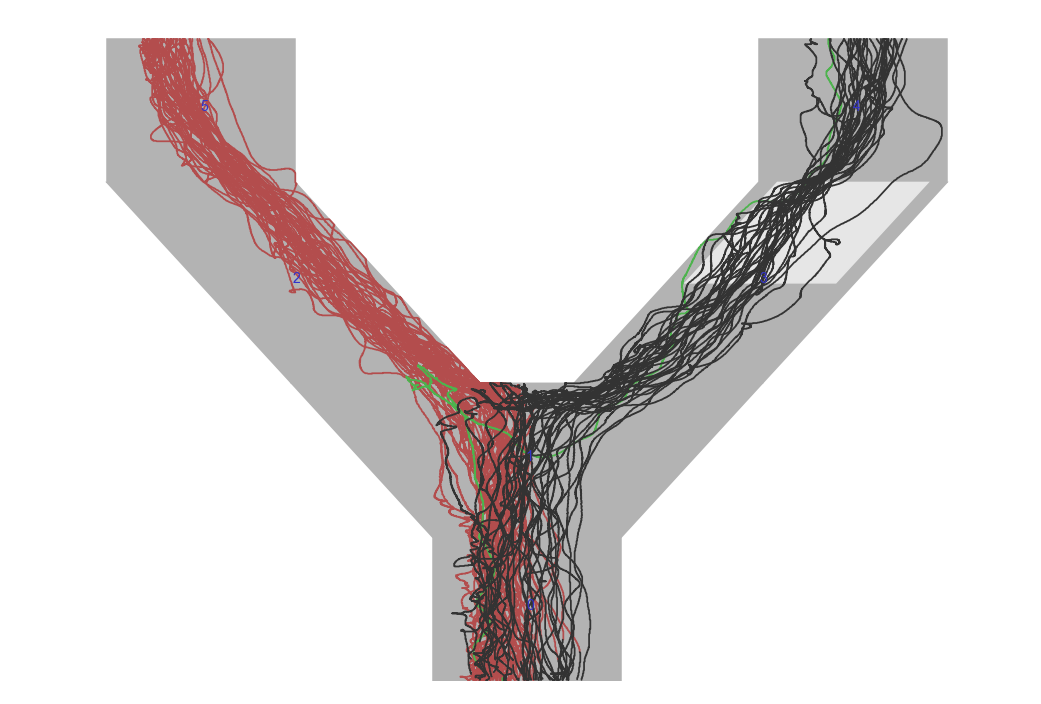

In [19]:
#For the Water-bias maze (left or right)

plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)
branchId = 5 #wrong end regardless of maze
keepE = trialEntered(branchId)

if maze[0].get('name') == 'OneChoiceRWcts.mat':
    branchId = 2 #water on the right, where 2 is incorrect
else:
    branchId = 3 #water on the left, where 3 is incorrect

keepW = trialEntered(branchId)


keepI = trial[(keepW.curBranchId == True) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keepI)
mvr.trace(session, keepI, [0.7, 0.3, 0.3]) #incorrect
keepS = trial[(keepW.curBranchId == True) & (keepE.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(keepS)
mvr.trace(session, keepS, [0.3, 0.7, 0.3]) #entered 3 but corrected itself
keepC = trial[(keepW.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(keepC)
mvr.trace(session, keepC, [0.2, 0.2, 0.2]) #correct

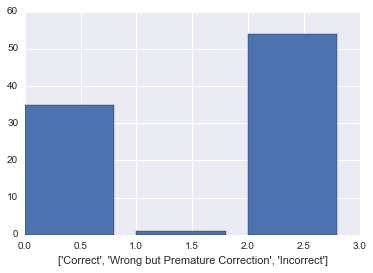

In [20]:
classified = [len(keepC), len(keepS),len(keepI)]
numtrls = sum(classified)
plt.bar(range(0,len(classified)),classified)
plt.xlabel(['Correct', 'Wrong but Premature Correction', 'Incorrect'])

# Create dot plot

([<matplotlib.axis.YTick at 0x1115eab90>,
 <a list of 2 Text yticklabel objects>)

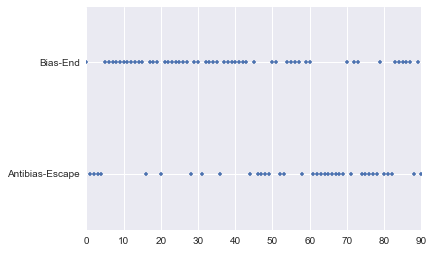

In [21]:
plt.plot(trialEntered(5),'.')
plt.ylim((-0.5,1.5))
plt.yticks([0,1],['Antibias-Escape','Bias-End'])
#in which 1 = left and 0 = right

In [22]:
#Classified into array

def init_choice(numtrials):    
    choices = ["" for x in range(numtrials)]

    for x in range(len(choices)):
        if maze[0].get('name') == 'OneChoiceLcts.mat': #water on the left
            if x in keepI:
                choices[x] = "R"
            elif x in keepS:
                choices[x] = "RL"
            else:
                choices[x] = "L"
        else: # water on the right
            if x in keepI:
                choices[x] = "L"
            elif x in keepS:
                choices[x] = "LR"
            else:
                choices[x] = "R"
    return choices
choices = init_choice(numtrls)
trial ['Trajectory'] = choices
trial['initChoice']   = [x[:1] for x in choices] 
#print trial

In [23]:
#Total bias split, based on initial choices

percent_correct = len(keepC)/float(numtrls)
percent_wrong = (len(keepS)+len(keepI))/float(numtrls)
percent_qswitch = len(keepS)/float(numtrls)

print percent_correct,percent_wrong, percent_qswitch

0.388888888889 0.611111111111 0.0111111111111


In [24]:
def completion(session, numtrials):
    finish = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        if (stop-start) > 119:
            entry = False
        else:
            entry = True
        finish.append(entry)
    return finish

complete = completion(session,numtrls)
#print len(complete)
#print numtrls
trial['Completed'] = complete

incomplete = complete.count(False)
percent_unfin = incomplete/float(len(complete))
print incomplete,percent_unfin


1 0.0111111111111


In [25]:
def trial_time(session, numtrials):
    seconds = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        seconds.append(stop-start)
    return seconds    
        
times = trial_time(session,numtrls)

trial['time'] = times
#print trial

In [26]:
def choice_time(session,numtrials):
    think = []
    straight = []
    choicept = 1
    entrance = 0
    
    for n in range(numtrials):
        start1 = session[session.number==n].time[session.curBranchId == choicept].min()
        stop1 = session[session.number==n].time[session.curBranchId == choicept].max()
        start0 = session[session.number==n].time[session.curBranchId == entrance].min()
        stop0 = session[session.number==n].time[session.curBranchId == entrance].max()
        think.append(stop1-start1)
        straight.append(stop0-start0)
    return think,straight

t_choosing,t_straight = choice_time(session,numtrls)
trial['timeChoice'] = t_choosing
trial['timeStraight'] = t_straight
#print trial

In [27]:
def choice_time(session,numtrials):
    think = []
    straight = []
    choicept = 1
    entrance = 0
    dt = 0.002
    for n in range(numtrials):
        in1 = len(session[session.number==n].time[session.curBranchId==choicept])*dt
        in0 = len(session[session.number==n].time[session.curBranchId==entrance])*dt
        
        think.append(in1)
        straight.append(in0)
    return think,straight

t_choosing,t_straight = choice_time(session,numtrls)
trial['timeStraight'] = t_straight
trial['timeChoice'] = t_choosing

#print trial

In [28]:
def initchoice_time(session,numtrials):
    dt = 0.002 #seconds per timestep
    initchoice_t = []
    for n in range(numtrials):
        inchoice = [(session.curBranchId==1) & (session.number==n)]
        if len(np.nonzero(inchoice)[1])==0:
            initchoice_t.append(0)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        inchoice = list(inchoice[0][enter1:])
        exit1 = enter1 + inchoice.index(0)
        initchoice_t.append((exit1-enter1)*dt)
    return initchoice_t

initchoice_t= initchoice_time(session,numtrls)
trial['initChoiceTime'] = initchoice_t
#trial    

In [29]:
import math
def Idphi(x,y,degree=3):
    '''
    x and y arrays must have the same dimensions
    Implements arclength formula to estimate the total length of a fitted spline (cubic default)
    
    Returns: idphi
    ''' 
    
    t = range(len(x)) #time series
    dx_array = np.diff(x)
    dy_array = np.diff(y)
    d = range(len(dx_array))
    phi = [math.atan2(dy_array[i],dx_array[i]) for i in d]
    phi = np.unwrap(phi)
    phispline = interpolate.UnivariateSpline(range(len(phi)),phi, k=degree)
   
    dphispline = phispline.derivative()
    '''
    plt.plot(x,y)
    plt.xlim(0,70)
    plt.figure()
    plt.plot(phi)
    plt.plot(d,phispline(d))
    plt.figure()
    plt.plot(d,dphispline(d))
    '''
    
    dphi = [abs(i) for i in dphispline(d)]
    result = sum(dphi)
    
    return result
    
x = [10,10,10,10,20,30,40,50,60,60,60]
y = [0,10,20,30,30,30,30,30,30,50,60]

Idphi(x,y)  

4.6760788088834069

In [30]:
def get_idphi(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    idphi = []    
    for t in trial : 
        inchoice = [(session.curBranchId==1) & (session.number==t)]
        
        if len(np.nonzero(inchoice)[1])==0:
            idphi.append(np.nan)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        
        inchoice = list(inchoice[0][enter1:])

        exit1 = enter1 + inchoice.index(0)
        
        exitbranch = session.curBranchId[(session.trialIndex==exit1)].values[0]
        
        if not (exitbranch ==2 or exitbranch==3):
            idphi.append(np.nan)
            continue 
        
        xCord = session.xMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values
        yCord = session.yMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values 
       
        idphi.append(Idphi(xCord,yCord))
    return idphi

idphi = get_idphi(session,keep)
trial['IdPhi'] = idphi     

In [31]:
zidphi = ((trial.IdPhi - trial.IdPhi.mean())/trial.IdPhi.std(ddof=0))
#print zidphi
trial['zIdPhi'] = zidphi

In [32]:
newfolder = path+'/summary'

In [33]:
os.mkdir(newfolder)

In [34]:
trial.to_csv(newfolder + '/trial_summary164.csv')

In [35]:
trial

,trialType,reward,rEnd,lEnd,Pathlengths,choicePath,initChoicePath,Trajectory,initChoice,Completed,time,timeChoice,timeStraight,initChoiceTime,IdPhi,zIdPhi
number,,,,,,,,,,,,,,,,
0,0,0,0,0,95.088296,18.317631,18.264337,L,L,True,5.298,0.878,1.730,0.878,1.516944,-0.455470
1,0,1,0,0,99.521470,18.311251,18.245945,R,R,True,22.100,18.602,1.074,18.602,9.169925,-0.069406
2,0,1,0,0,97.342367,23.475741,23.436151,R,R,True,4.038,1.170,0.722,1.170,0.841840,-0.489527
3,0,1,0,0,89.402749,25.432322,25.375991,R,R,True,4.736,1.412,0.828,1.412,0.833506,-0.489947
4,0,1,0,0,100.253708,23.488549,23.411803,R,R,True,23.116,1.854,0.920,1.854,17.819027,0.366909
5,0,0,0,0,105.715722,12.391208,12.343663,L,L,True,25.140,22.418,0.762,22.418,8.805452,-0.087792
6,0,0,0,0,89.958698,19.582081,19.554567,L,L,True,4.692,1.036,1.196,1.036,0.562467,-0.503620
7,0,0,0,0,92.446325,10.114137,10.114911,L,L,True,22.720,19.668,1.172,19.668,0.378150,-0.512918
8,0,0,0,0,90.103888,19.534043,19.500047,L,L,True,5.318,1.488,0.964,1.488,0.479551,-0.507803
